# Fake News Detection: Can we build a classifier that can accurately detect fake news?

In [46]:
from imports import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk

plt.rc('figure', figsize=(10, 7))
plt.style.use('fivethirtyeight')

### Initial exploration 

In [47]:
true_df = pd.read_csv('True.csv')

true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [48]:
fake_df = pd.read_csv('Fake.csv')

fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [49]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [50]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


<AxesSubplot:>

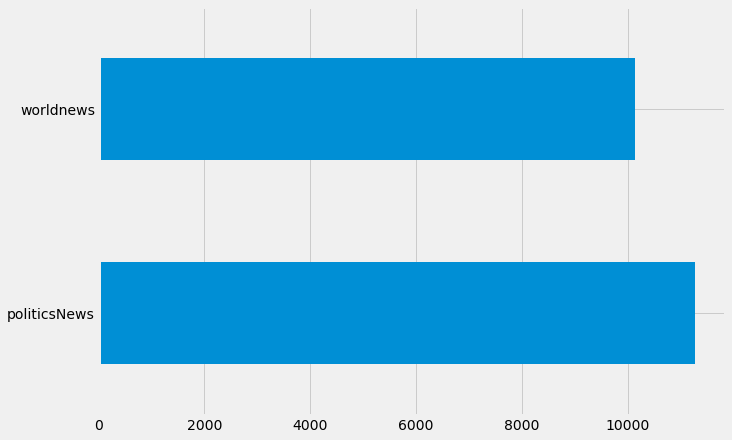

In [51]:
true_df.subject.value_counts().plot.barh()

<AxesSubplot:>

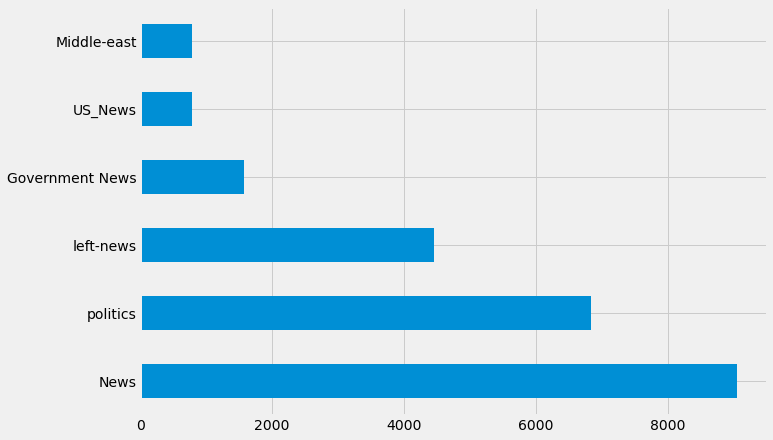

In [52]:
fake_df.subject.value_counts().plot.barh()

In [53]:
print(true_df.text[0])

WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educati

In [54]:
len(true_df.text[0].split())

749

In [55]:
print(fake_df.text[0])

Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t eve

In [56]:
len(fake_df.text[0].split())

495

In [57]:
print(true_df.title[0])
print(fake_df.title[0])

As U.S. budget fight looms, Republicans flip their fiscal script
 Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing


### Initial takeaways:

- True news articles have a preamble/external in the format: "CITY (News Association)- "
- There are only two subject types in true articles, but six in fake articles

### Initial data prep/wrangle plan:

- Add a boolean truth value column corresponding to each df
- Standardize columns for ease of access/manipulation (to names that are not reserved words)
- Reorganize subject types
- Prepare text:
    * Make a version of true article that is stripped of externals like "CITY (News Association)- " for ML comparisons
    * Clean fake articles
- Join dfs on axis 0
- ~~Set index to date~~
- Get word counts for articles (as engineered feature)
    

### Add a boolean truth value column corresponding to each df

In [58]:
# Set truth values for each df
true_df['truth_value'] = True
fake_df['truth_value'] = False


### Standardize columns for ease of access/manipulation (to names that are not reserved words)

In [59]:
# Standardize columns
true_df.rename(columns= {'title':'article_headline', 'text': 'article_body'}, inplace=True)
fake_df.rename(columns= {'title':'article_headline', 'text': 'article_body'}, inplace=True)
# Print out column lists to check
print(f'True DF columns:\n{true_df.columns}')
print(f'Fake DF columns:\n{fake_df.columns}')

True DF columns:
Index(['article_headline', 'article_body', 'subject', 'date', 'truth_value'], dtype='object')
Fake DF columns:
Index(['article_headline', 'article_body', 'subject', 'date', 'truth_value'], dtype='object')


### Reorganize subject types

In [60]:
# Organize subject types in true_df
true_df.subject.replace(to_replace='politicsNews', value='politics', inplace=True)
true_df.subject.replace(to_replace= 'worldnews', value='world', inplace=True)
# Check values
true_df.subject.value_counts()

politics    11272
world       10145
Name: subject, dtype: int64

In [61]:
fake_df.subject.value_counts().index

Index(['News', 'politics', 'left-news', 'Government News', 'US_News',
       'Middle-east'],
      dtype='object')

In [62]:
# Organize subject types in fake_df
fake_df.subject.replace(
    to_replace= ['News', 'politics', 'left-news', 'Government News', 'US_News','Middle-east'],
    value= ['politics', 'politics', 'politics', 'politics', 'world', 'world'],
    inplace= True)

fake_df.subject.value_counts()

politics    21920
world        1561
Name: subject, dtype: int64

### Prepare text:

- Make a version of true article that is stripped of externals like "CITY (News Association)- " for ML comparisons
- Clean articles

In [63]:
# Encode the preamble in 'True' articles with regex to remove it in a later engineered feature
regexp_true = r'\w*\S?\w*\s\(\w*\)\s\S'
#true_df.article_body.str.replace(r'\w*\S?\w*\s\(\w*\)\s\S', '')
import warnings
warnings.filterwarnings('ignore')

In [64]:
import prep

true_df['article_clean'] = true_df.article_body.str.replace(regexp_true, '')
true_df.article_clean = true_df.article_clean.apply(prep.basic_clean)

true_df.head(3)

,article_headline,article_body,subject,date,truth_value,article_clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politics,"December 31, 2017",True,the head of a conservative republican faction...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politics,"December 29, 2017",True,transgender people will be allowed for the fi...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politics,"December 31, 2017",True,the special counsel investigation of links be...


In [65]:
true_df.date.sort_values()

10099        April 1, 2016 
10019        April 1, 2016 
10020        April 1, 2016 
10092        April 1, 2016 
10094        April 1, 2016 
                ...        
20543    September 9, 2017 
20542    September 9, 2017 
20540    September 9, 2017 
20555    September 9, 2017 
20549    September 9, 2017 
Name: date, Length: 21417, dtype: object

In [66]:
fake_df['article_clean'] = fake_df.article_body.apply(prep.basic_clean)

fake_df.head(3)

,article_headline,article_body,subject,date,truth_value,article_clean
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,politics,"December 31, 2017",False,donald trump just couldn t wish all americans ...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,politics,"December 31, 2017",False,house intelligence committee chairman devin nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",politics,"December 30, 2017",False,on friday it was revealed that former milwauke...


In [67]:
fake_df.date.sort_values()

9084                                             14-Feb-18
9075                                             15-Feb-18
9076                                             15-Feb-18
9077                                             15-Feb-18
9078                                             15-Feb-18
                               ...                        
17433    https://fedup.wpengine.com/wp-content/uploads/...
15840    https://fedup.wpengine.com/wp-content/uploads/...
15839    https://fedup.wpengine.com/wp-content/uploads/...
17432    https://fedup.wpengine.com/wp-content/uploads/...
21869    https://fedup.wpengine.com/wp-content/uploads/...
Name: date, Length: 23481, dtype: object

In [68]:
fake_rows_todrop = fake_df[fake_df.date.str.contains('https')].index

fake_df = fake_df.drop(labels= fake_rows_todrop)
fake_df.date.sort_values().tail()

4705    September 9, 2016
404     September 9, 2017
405     September 9, 2017
406     September 9, 2017
407     September 9, 2017
Name: date, dtype: object

In [69]:
print(true_df.columns)
print(fake_df.columns)

Index(['article_headline', 'article_body', 'subject', 'date', 'truth_value',
       'article_clean'],
      dtype='object')
Index(['article_headline', 'article_body', 'subject', 'date', 'truth_value',
       'article_clean'],
      dtype='object')


In [70]:
df = pd.concat([true_df, fake_df], axis=0)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44889 entries, 0 to 23480
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   article_headline  44889 non-null  object
 1   article_body      44889 non-null  object
 2   subject           44889 non-null  object
 3   date              44889 non-null  object
 4   truth_value       44889 non-null  bool  
 5   article_clean     44889 non-null  object
dtypes: bool(1), object(5)
memory usage: 2.1+ MB


,article_headline,article_body,subject,date,truth_value,article_clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politics,"December 31, 2017",True,the head of a conservative republican faction...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politics,"December 29, 2017",True,transgender people will be allowed for the fi...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politics,"December 31, 2017",True,the special counsel investigation of links be...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politics,"December 30, 2017",True,trump campaign adviser george papadopoulos to...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politics,"December 29, 2017",True,president donald trump called on the us posta...


In [71]:
df[df.date.str.contains('MSNBC')]

,article_headline,article_body,subject,date,truth_value,article_clean
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,politics,MSNBC HOST Rudely Assumes Steel Worker Would N...,False,vcrowvccolumn width tdblocktrendingnow limit ...


In [72]:
df = df.drop(labels= [18933])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44887 entries, 0 to 23480
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   article_headline  44887 non-null  object
 1   article_body      44887 non-null  object
 2   subject           44887 non-null  object
 3   date              44887 non-null  object
 4   truth_value       44887 non-null  bool  
 5   article_clean     44887 non-null  object
dtypes: bool(1), object(5)
memory usage: 2.1+ MB


In [73]:
df.date = pd.to_datetime(df.date)
#df = df.set_index(df.date)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44887 entries, 0 to 23480
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   article_headline  44887 non-null  object        
 1   article_body      44887 non-null  object        
 2   subject           44887 non-null  object        
 3   date              44887 non-null  datetime64[ns]
 4   truth_value       44887 non-null  bool          
 5   article_clean     44887 non-null  object        
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 2.1+ MB


,article_headline,article_body,subject,date,truth_value,article_clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politics,2017-12-31,True,the head of a conservative republican faction...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politics,2017-12-29,True,transgender people will be allowed for the fi...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politics,2017-12-31,True,the special counsel investigation of links be...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politics,2017-12-30,True,trump campaign adviser george papadopoulos to...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politics,2017-12-29,True,president donald trump called on the us posta...


In [74]:
df = df.sort_index(ascending=True)

df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44887 entries, 0 to 23480
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   article_headline  44887 non-null  object        
 1   article_body      44887 non-null  object        
 2   subject           44887 non-null  object        
 3   date              44887 non-null  datetime64[ns]
 4   truth_value       44887 non-null  bool          
 5   article_clean     44887 non-null  object        
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 2.1+ MB


,article_headline,article_body,subject,date,truth_value,article_clean
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,world,2016-01-16,False,st century wire says as wire reported earlier ...
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,world,2016-01-16,False,st century wire says it s a familiar theme whe...
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,world,2016-01-15,False,patrick henningsen st century wireremember wh...
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,world,2016-01-14,False,st century wire says al jazeera america will g...
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,world,2016-01-12,False,st century wire says as wire predicted in its ...


In [75]:
def get_word_count(col):
    col = pd.Series(col)

    for i in col:
        len(i.split())
    return len(i.split())

df['raw_wd_count'] = df.article_body.apply(get_word_count)
df.head()


,article_headline,article_body,subject,date,truth_value,article_clean,raw_wd_count
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politics,2017-12-31,True,the head of a conservative republican faction...,749
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,politics,2017-12-31,False,donald trump just couldn t wish all americans ...,495
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,politics,2017-12-31,False,house intelligence committee chairman devin nu...,305
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politics,2017-12-29,True,transgender people will be allowed for the fi...,624
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politics,2017-12-31,True,the special counsel investigation of links be...,457


In [76]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39114 entries, 0 to 22702
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   article_headline  39114 non-null  object        
 1   article_body      39114 non-null  object        
 2   subject           39114 non-null  object        
 3   date              39114 non-null  datetime64[ns]
 4   truth_value       39114 non-null  bool          
 5   article_clean     39114 non-null  object        
 6   raw_wd_count      39114 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(1), object(4)
memory usage: 2.1+ MB


In [77]:
df.article_clean = df.article_clean.apply(prep.tokenize)\
    .apply(prep.remove_stopwords)

df.head(3)

,article_headline,article_body,subject,date,truth_value,article_clean,raw_wd_count
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politics,2017-12-31,True,head conservative republican faction us congre...,749
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,politics,2017-12-31,False,donald trump wish americans happy new year lea...,495
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,politics,2017-12-31,False,house intelligence committee chairman devin nu...,305


In [78]:
df['article_stemmed'] = df.article_body.apply(prep.basic_clean)\
    .apply(prep.tokenize)\
        .apply(prep.stem)\
            .apply(prep.remove_stopwords)

df['article_lemmatized'] = df.article_body.apply(prep.basic_clean)\
    .apply(prep.tokenize)\
        .apply(prep.lemmatize)\
            .apply(prep.remove_stopwords)

df.head(3)

,article_headline,article_body,subject,date,truth_value,article_clean,raw_wd_count,article_stemmed,article_lemmatized
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politics,2017-12-31,True,head conservative republican faction us congre...,749,washington reuter head conserv republican fact...,washington head conservative republican factio...
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,politics,2017-12-31,False,donald trump wish americans happy new year lea...,495,donald trump wish american happi new year leav...,donald trump wish american happy new year leav...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,politics,2017-12-31,False,house intelligence committee chairman devin nu...,305,hous intellig committe chairman devin nune go ...,house intelligence committee chairman devin nu...


In [79]:
df.to_csv('fake_news_detection.csv', index=False)

End wrangle/prep.

### NLP exploration

- What are the most common words in these articles? 
    - What are the most common words in fake articles?
    - What are the most common words in real articles?

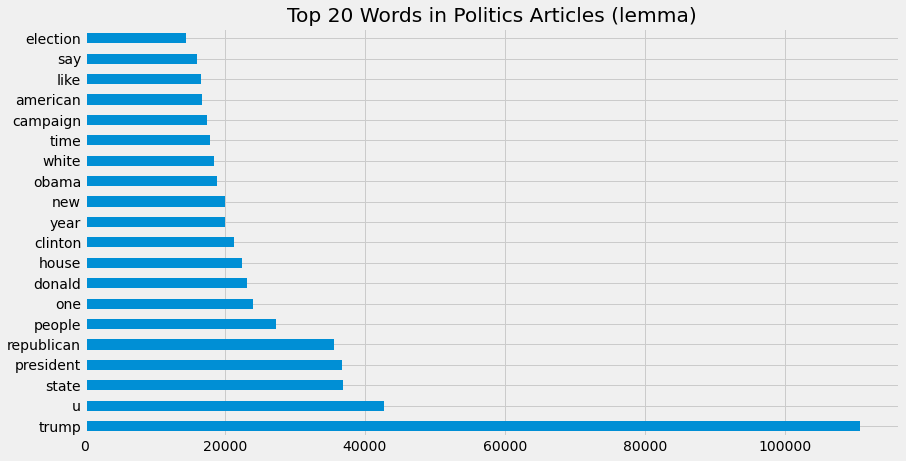

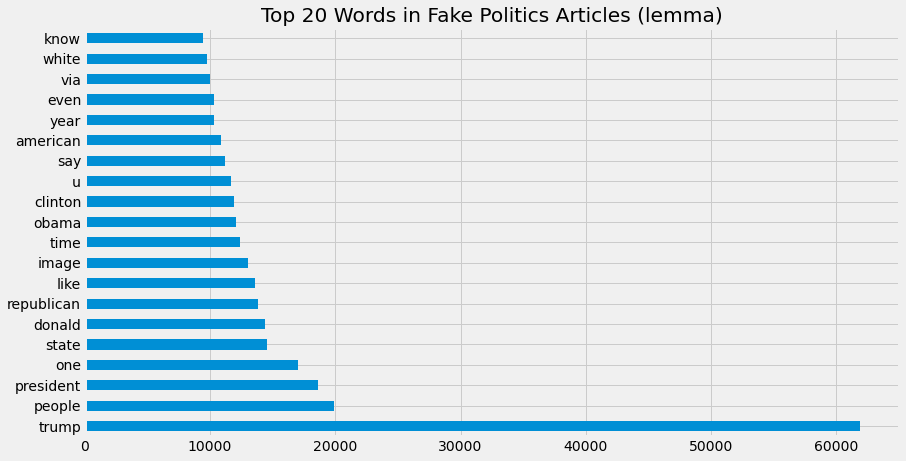

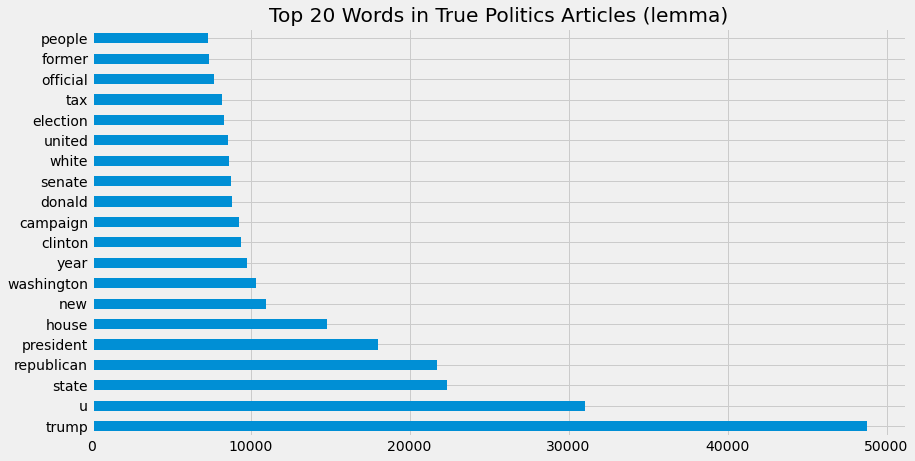

In [80]:
# Make corpus of lemmatized politics articles
pol_lem_corpus = ' '.join(df[df.subject == 'politics'].article_lemmatized)
pol_lem_corpus = pol_lem_corpus.split()
pol_lem_freq = pd.Series(pol_lem_corpus).value_counts()

# Visualize Top 20 most common words in politics articles

plt.figure(figsize=(13,7))
pol_lem_freq.sort_values(ascending=False).head(20).plot.barh()
plt.title('Top 20 Words in Politics Articles (lemma)')

plt.show()


fake_pol_corpus = ' '.join(df[(df.subject == 'politics') & (df.truth_value == False)].article_lemmatized)
fake_pol_corpus = fake_pol_corpus.split()
fake_pol_freq = pd.Series(fake_pol_corpus).value_counts()

plt.figure(figsize= (13,7))
fake_pol_freq.sort_values(ascending=False).head(20).plot.barh()
plt.title('Top 20 Words in Fake Politics Articles (lemma)')

plt.show()

true_pol_corpus = ' '.join(df[(df.subject == 'politics') & (df.truth_value == True)].article_lemmatized)
true_pol_corpus = true_pol_corpus.split()
true_pol_freq = pd.Series(true_pol_corpus).value_counts()

plt.figure(figsize= (13,7))
true_pol_freq.sort_values(ascending=False).head(20).plot.barh()
plt.title('Top 20 Words in True Politics Articles (lemma)')

plt.show()

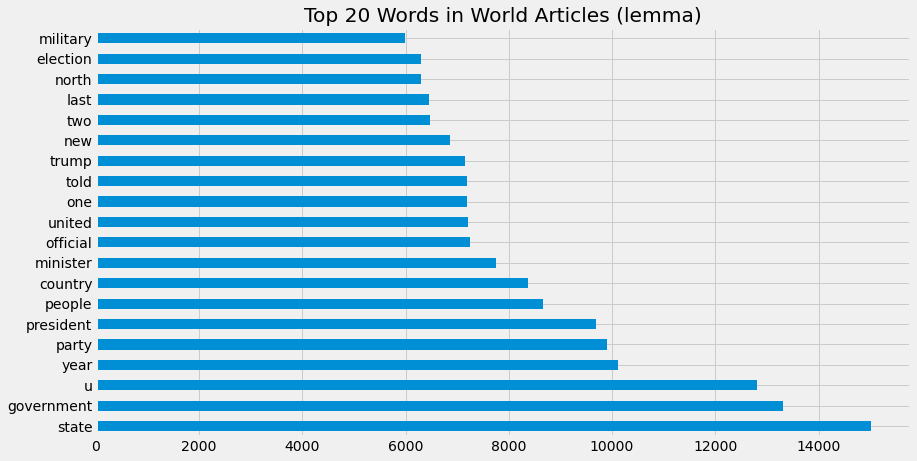

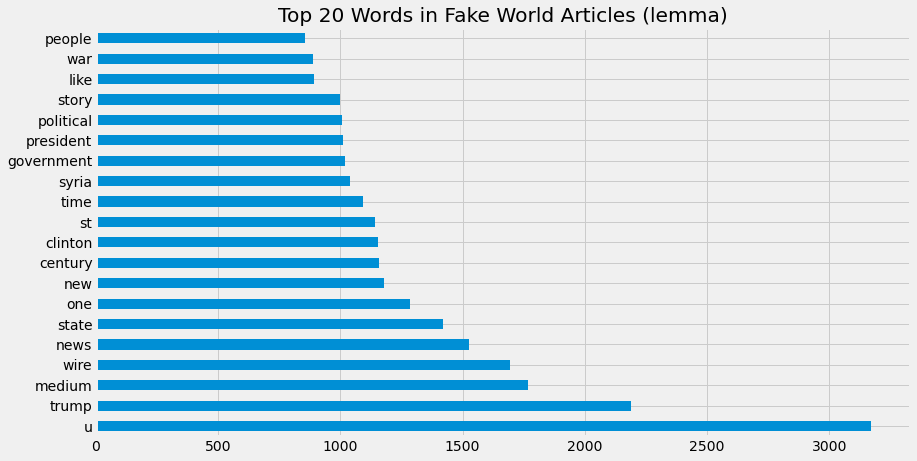

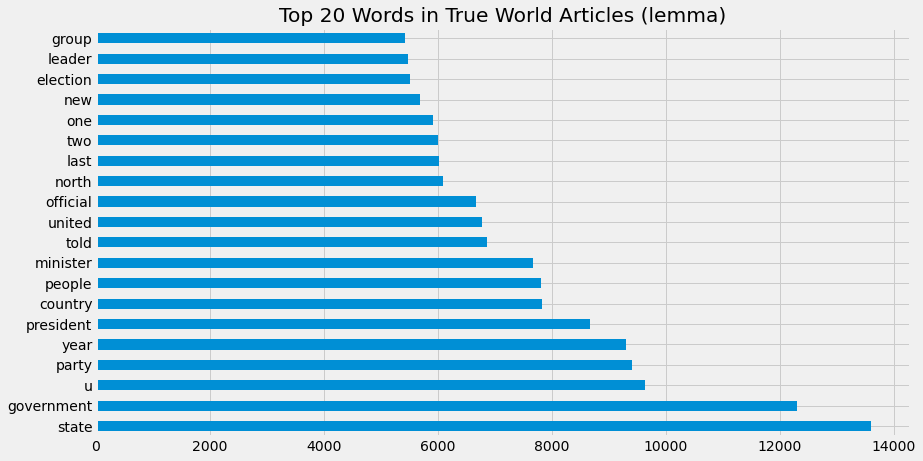

In [81]:
# Visualize top 20 most common words in 'world' subject

# Make corpus of lemmatized world articles
world_lem_corpus = ' '.join(df[df.subject == 'world'].article_lemmatized)
world_lem_corpus = world_lem_corpus.split()
# Get word counts
world_lem_freq = pd.Series(world_lem_corpus).value_counts()

# Visualize top 20 common words in world articles overall
plt.figure(figsize=(13,7))
world_lem_freq.sort_values(ascending=False).head(20).plot.barh()
plt.title('Top 20 Words in World Articles (lemma)')

plt.show()

# Make corpus of lemmatized world articles for fake news subset
fake_world_corpus = ' '.join(df[(df.subject == 'world') & (df.truth_value == False)].article_lemmatized)
fake_world_corpus = fake_world_corpus.split()
fake_world_freq = pd.Series(fake_world_corpus).value_counts()

plt.figure(figsize= (13,7))
fake_world_freq.sort_values(ascending=False).head(20).plot.barh()
plt.title('Top 20 Words in Fake World Articles (lemma)')

plt.show()

# Make corpus of lemmatized world articles for true news subset
true_world_corpus = ' '.join(df[(df.subject == 'world') & (df.truth_value == True)].article_lemmatized)
true_world_corpus = true_world_corpus.split()
true_world_freq = pd.Series(true_world_corpus).value_counts()

plt.figure(figsize= (13,7))
true_world_freq.sort_values(ascending=False).head(20).plot.barh()
plt.title('Top 20 Words in True World Articles (lemma)')

plt.show()

### Takeaways: 
- 'Trump' appears in five out of six of the above top 20 listings. 
- The letter 'u' appears in all six. Further investigation is necessary, but we must also consider the probability of unigrams' limited usefulness beyond the initial survey of the corpus/sub-corpora.

In [82]:
article_corpora = [pol_lem_corpus, fake_pol_corpus, true_pol_corpus, world_lem_corpus, fake_world_corpus, true_world_corpus]
corpus_title = [
    'politics (lemma)', 
    'fake news politics (lemma)', 
    'true news politics (lemma)', 
    'world (lemma)', 
    'fake news world (lemma)', 
    'true news world (lemma)'
    ]

corpus_title = [title.capitalize() for title in corpus_title]
corpora_labels = pd.DataFrame(zip(corpus_title, article_corpora))
corpora_labels.rename(columns = {0: 'corpus_title', 1: 'corpus'}, inplace=True)


In [83]:
type(corpora_labels.corpus_title)

pandas.core.series.Series

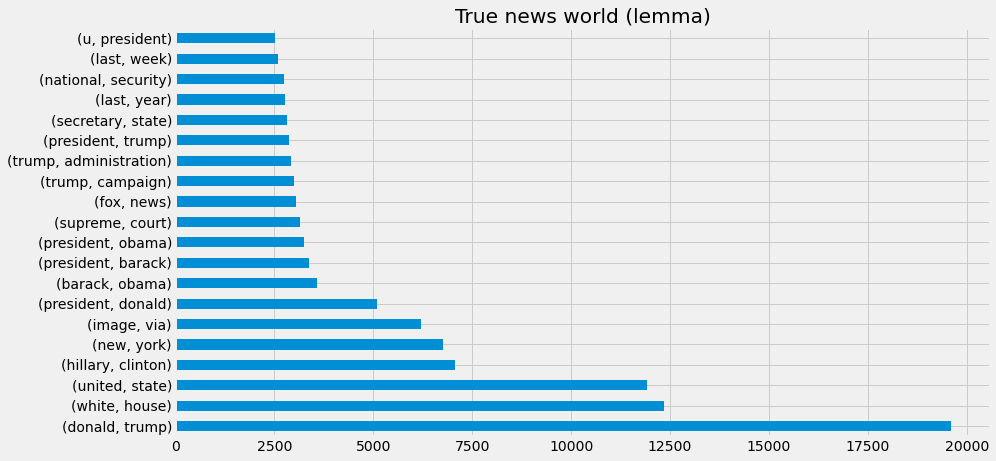

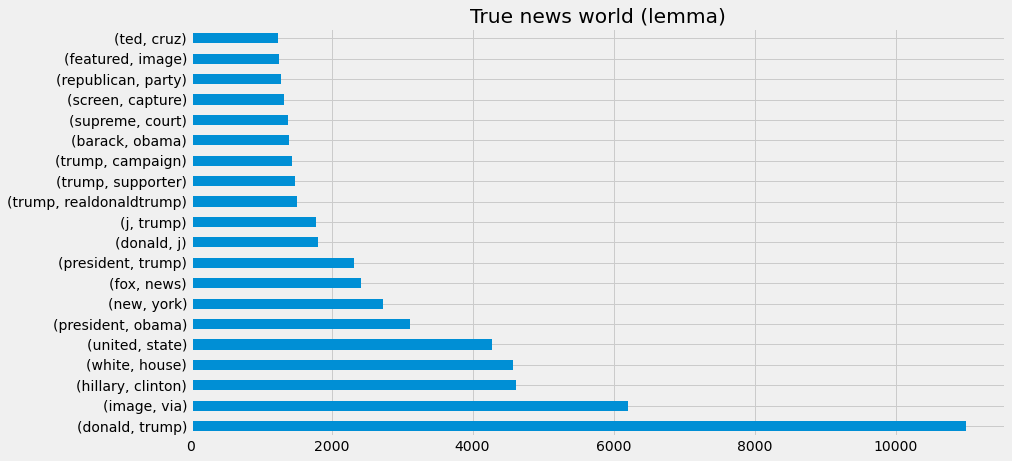

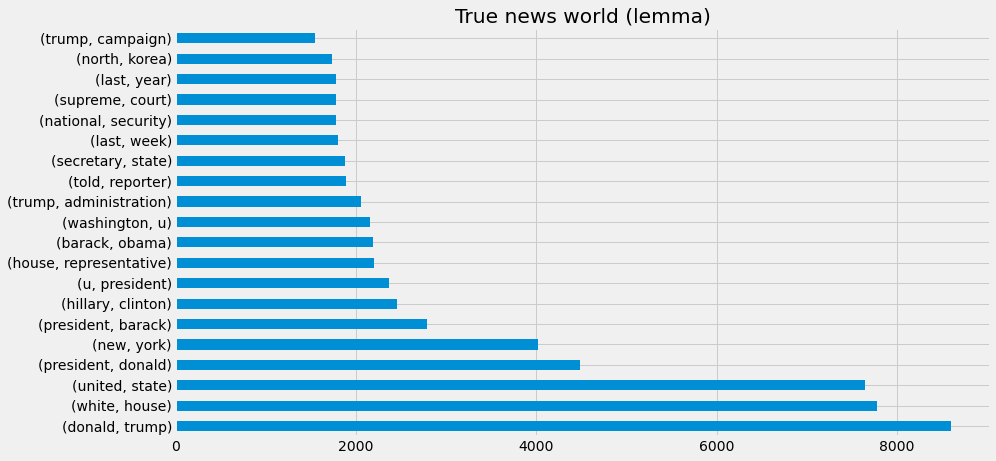

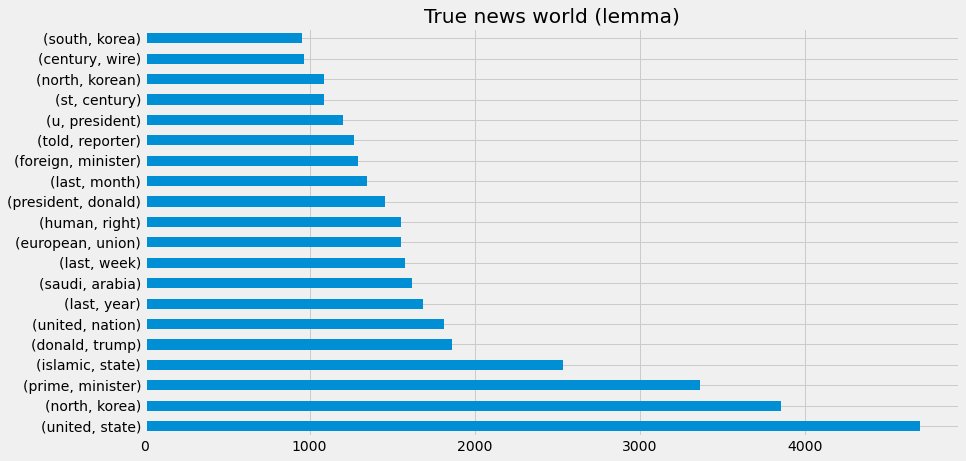

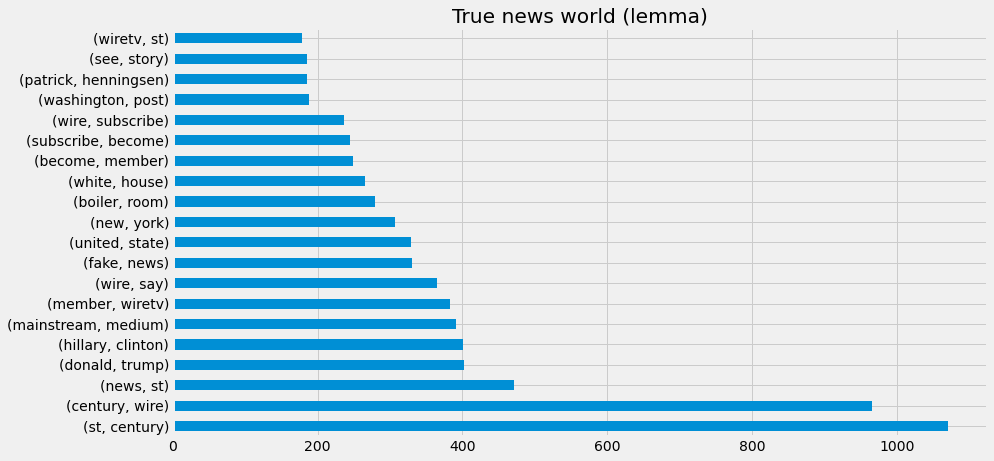

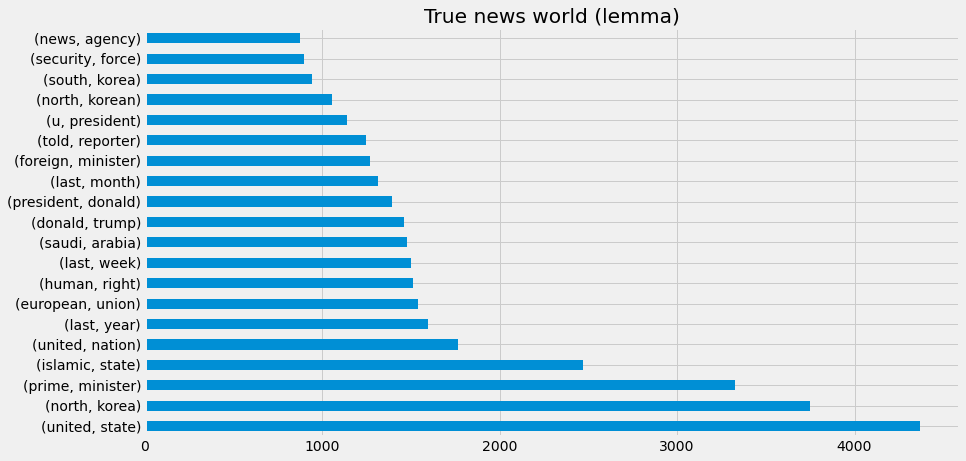

In [84]:
for corpus in article_corpora:
    corpus_freq = pd.Series(nltk.ngrams(corpus, 2)).value_counts().sort_values(ascending=False)
    
    plt.figure(figsize= (13,7))
    corpus_freq.head(20).plot.barh()
    title = corpus_title
    for i in title:
        plt.title(label=i)
    

    plt.show()

In [85]:
def top20_ngrams_viz(corpus, n_words, title=False):
    '''
    Takes in a corpus of words from the Fake News Detection dataset (df), an n number of words (n_words), and an optional title (string), 
    returns a horizontal bar graph of the top 20 most common occurrences of the word or group of words.
    '''
    corpus_freq = pd.Series(nltk.ngrams(corpus, n_words)).value_counts().sort_values(ascending=False)
    h_bar = corpus_freq.head(20).plot.barh()
    if title:
        plt.title(title)
    return h_bar

    

<AxesSubplot:title={'center':'Top 20 Trigrams in Politics Articles (lemma)'}>

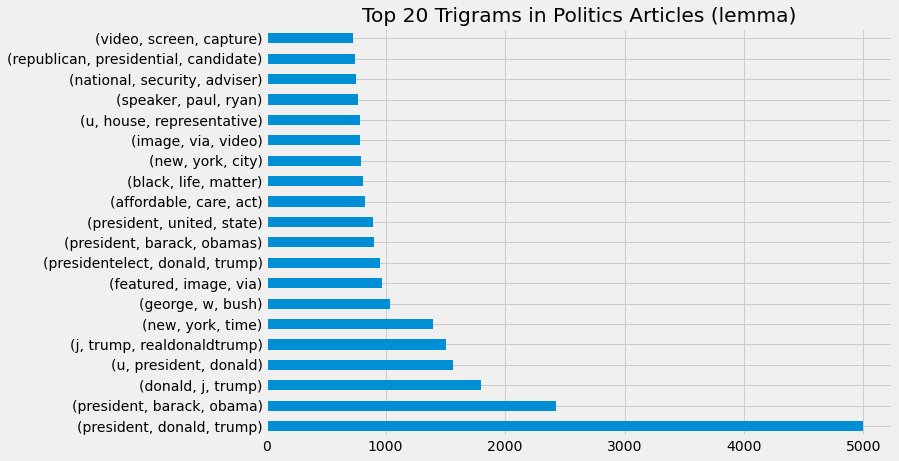

In [86]:
top20_ngrams_viz(pol_lem_corpus, 3, title='Top 20 Trigrams in Politics Articles (lemma)')

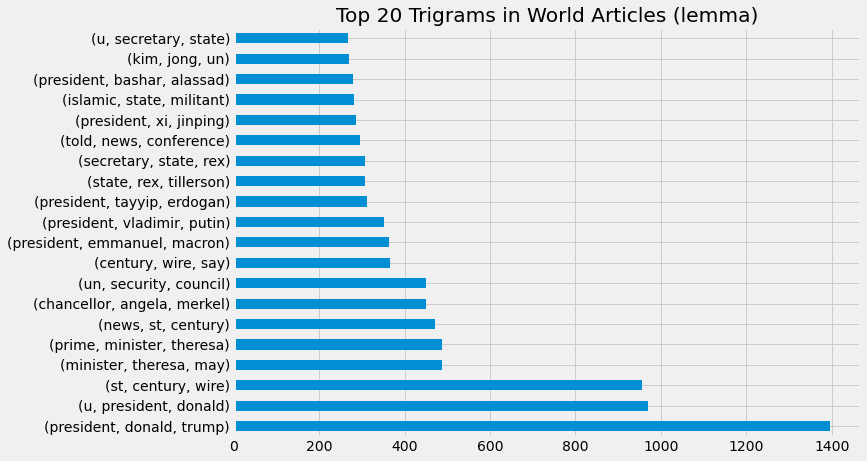

In [87]:
top20_ngrams_viz(world_lem_corpus, 3, title='Top 20 Trigrams in World Articles (lemma)')
plt.show()

In [88]:
df['truth_label'] = df.truth_value.astype('str')
df.head(3)

,article_headline,article_body,subject,date,truth_value,article_clean,raw_wd_count,article_stemmed,article_lemmatized,truth_label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politics,2017-12-31,True,head conservative republican faction us congre...,749,washington reuter head conserv republican fact...,washington head conservative republican factio...,True
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,politics,2017-12-31,False,donald trump wish americans happy new year lea...,495,donald trump wish american happi new year leav...,donald trump wish american happy new year leav...,False
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,politics,2017-12-31,False,house intelligence committee chairman devin nu...,305,hous intellig committe chairman devin nune go ...,house intelligence committee chairman devin nu...,False


In [89]:
u_articles = df[df.article_lemmatized.str.contains(' u ')]
u_articles[u_articles.truth_label == 'True'].article_lemmatized[0]

'washington head conservative republican faction u congress voted month huge expansion national debt pay tax cut called fiscal conservative sunday urged budget restraint keeping sharp pivot way among republican u representative mark meadow speaking cbs face nation drew hard line federal spending lawmaker bracing battle january return holiday wednesday lawmaker begin trying pas federal budget fight likely linked issue immigration policy even november congressional election campaign approach republican seek keep control congress president donald trump republican want big budget increase military spending democrat want proportional increase nondefense discretionary spending program support education scientific research infrastructure public health environmental protection trump administration already willing say going increase nondefense discretionary spending percent meadow chairman small influential house freedom caucus program democrat saying thats enough need give government pay raise

### Takeaways: Clear themes in bigrams and trigrams. Common word 'u' in appears to be the result of NLP (lemmatization) on the string 'U.S.'. Minor issue getting proper titles on n-gram viz automation still WIP.

### Start bivariate/multivariate exploration

- Make train/validate/test splits

In [92]:
# Make train/validate/test splits ()
from sklearn.model_selection import train_test_split
from prep import get_splits, isolate_lm_target

train, validate, test = get_splits(df)
X_train, y_train, X_validate, y_validate, X_test, y_test = isolate_lm_target(train, validate, test, 'truth_value')


In [97]:
# Check train df
train.info()
train.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21903 entries, 1910 to 20202
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   article_headline    21903 non-null  object        
 1   article_body        21903 non-null  object        
 2   subject             21903 non-null  object        
 3   date                21903 non-null  datetime64[ns]
 4   truth_value         21903 non-null  bool          
 5   article_clean       21903 non-null  object        
 6   raw_wd_count        21903 non-null  int64         
 7   article_stemmed     21903 non-null  object        
 8   article_lemmatized  21903 non-null  object        
 9   truth_label         21903 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(7)
memory usage: 1.7+ MB


,article_headline,article_body,subject,date,truth_value,article_clean,raw_wd_count,article_stemmed,article_lemmatized,truth_label
1910,House to consider disaster aid Wednesday,WASHINGTON (Reuters) - The U.S. House will con...,politics,2017-09-04,True,us house consider disaster relief package wedn...,68,washington reuter us hous consid disast relief...,washington u house consider disaster relief pa...,True
82,GOP Senator Caught On Hot Mic Trashing His Ow...,Senator Jeff Flake (R-AZ) is liberated now th...,politics,2017-11-18,False,senator jeff flake raz liberated announced ret...,289,senat jeff flake raz liber announc hi retir hi...,senator jeff flake raz liberated announced ret...,False
8101,"Trump gets skewered, Clinton finds support at ...",LOS ANGELES (Reuters) - As the U.S. presidenti...,politics,2016-09-19,True,los us presidential election draws near televi...,461,lo angel reuter us presidenti elect draw near ...,los angeles u presidential election draw near ...,True


In [96]:
train.groupby('truth_label').raw_wd_count.agg(['mean', 'median', 'min', 'max'])

,mean,median,min,max
truth_label,,,,
False,412.859900,372.0,0,7928
True,386.361337,360.0,0,5172
